# SHL AI Hiring Task: Automated Essay Scoring using NLP
------

Dataset derived from: https://drive.google.com/drive/folders/1zIoIniVDhLz-oFXVAmu1SMgWg9OmGZIl?usp=sharing

Questionnaire: https://docs.google.com/document/d/1UXtQ6fCWnGz9BZ6y2vYfVtwv22gUz1w3q7afopgy6GY/edit

*Coding initiated on 17th September 2021 at 3:53 pm by RSK*

## **STEP ZERO**: Pre-requisite prep
-------
1. Import all necessary libraries and set constant variables
2. Upload and Import train and test datasets


In [104]:
!pip install pyspellchecker
# import all necessary libraries

# For dataframes
import pandas as pd 

# For numerical arrays
import numpy as np 

# For stemming/Lemmatisation/POS tagging
import spacy

# For getting stopwords
from spacy.lang.en.stop_words import STOP_WORDS

# For K-Fold cross validation
from sklearn.model_selection import KFold

# For visualizations
import matplotlib.pyplot as plt

# For regular expressions
import re

# For handling string
import string

# For all torch-supported actions
import torch

# For spell-check
from spellchecker import SpellChecker

# For performing mathematical operations
import math

# For dictionary related activites
from collections import defaultdict

# For counting actions (EDA)
from collections import  Counter

# For count vectorisation (EDA)
from sklearn.feature_extraction.text import CountVectorizer

# For one-hot encoding
from tensorflow.keras.utils import to_categorical

# For DL model
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from tensorflow.keras.models import Model, Sequential

# For generating random integers
from random import randint

# For TF-IDF vectorisation
from sklearn.feature_extraction.text import TfidfVectorizer

# For padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

# For tokenization
from tensorflow.keras.preprocessing.text import Tokenizer

# For plotting
import seaborn as sns

print("Necessary libraries imported")

# Constant variables 

# spaCy language lemmatiser model
sp=spacy.load('en_core_web_sm')
spell = SpellChecker()

# CONSTANTS FOR TRAINING
MAX_SEQUENCE_LENGTH = 500
MAX_NUM_WORDS = 5000 
EMBEDDING_DIM = 100 
VALIDATION_SPLIT = 0.2

print("Constant variables ready")

Necessary libraries imported
Constant variables ready


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [105]:
# import train and test datasets

'''df=pd.read_csv('/content/sample_data/train.csv')
test_df=pd.read_csv('/content/sample_data/test.csv')
df=df.drop(['Unnamed: 0'], axis=1)
'''
df=pd.read_csv('/content/prepared.csv')
df.head()

,Unnamed: 0,promptId,uniqueId,essay,evaluator_rating,avg_char_per_word,total_words,corpus,class
0,0,1,1_323,"At present age, our education system is not go...",3.0,4.59,306,present age education system good thing requir...,6.0
1,1,1,1_238,I am agree the tightly defined curriculum of o...,4.0,5.78,299,agree tightly define curriculum education syst...,8.0
2,2,1,1_212,I strongly agree with the statement that tight...,2.0,4.78,158,strongly agree statement tight schedule educat...,4.0
3,3,1,1_117,Our education system is nice quitely but i dis...,2.0,4.91,312,education system nice quitely disagree change ...,4.0
4,4,1,1_229,i am totally agree with the statement that tig...,3.0,4.36,339,totally agree statement tightly define curricu...,6.0


## **STEP ONE**: Exploratory Data Analysis
-------
1. View the basic characteristics of the training dataset
2. Inspect key properties of essays like number of words, number of characters per word, most used word and least used word, etc.


In [5]:
#basic observable characteristics 
print("shape of dataset: ",df.shape)
print("sample essay: ",df.essay.iloc[randint(0,len(df))])
print("Total null values: \n",df.isnull().sum())

shape of dataset:  (1240, 4)
sample essay:  I DO NOT AGREE, THAT WE HAVE BECOME SLAVES TO THE TECHNOLOGY, AS WE ARE THE ONE WHO ARE THE CREATORS OF THE TECHNOLOGY AND IN TIME WHEN THEY GOT BREAKDOWN WE ARE THE ONE WHO CAN REPAIR THEM. YES AT SOME POINT TECHNOLOGY IS HELPFULL ALSO AS IT SAVES OUR TIME ALSO, BUT WE ALSO REQUIRE MANPOWER FOR THE SMOOTH FUNCTIONING OF THIS TECHNOLOGY AS THEY REQUIRE UPDATES ON SEVERAL POINT OF TIME.ON THE CONTRARY IT IS TRUE THAT IN FEW YEARS THE TIME IS COMMING THAT MAY BE WE CAN BECOME THE SLAVES OF THE TECHNOLOGY AS WE CANT LIVE WITHOUT THEM FOR EXAMPLE MOBILE PHONES BECAME THE IMPORTANT PART OF OUR LIFE, WE CAN LIVE WITHOUT FOOD FOR SOMEDAYS BUT NOT WITHOUT MOBILE PHONES.MAN CREATE TECHNOLOGY FOR THEIR OWN GOOD BUT IT IS ALSO GOOD THAT THE MACHINES ALSO REQUIRE SOME ADVANCEMENT AND THIS CAN ONLY BE DONE BY A MAN.MACHINES DONT HAVE ANY FEELINGS THEY ARE JUST A PIECE OF METAL TIED UP WITH BOLT AND NUTS. THEY DONT HAVE POWER TO MAKE US SLAVES, BUT THE CAS

In [6]:
# For getting word-len characteristics of essays

def get_avg_len(text):
  words=text.split()
  word_len=0
  for word in words:
    word_len+=len(word)
  
  ret= round(word_len/len(words),2)
  return ret

def total_words(text):
  words=text.split()
  return len(words)

df['avg_char_per_word']=df.essay.apply(lambda x: get_avg_len(x))
df['total_words']=df.essay.apply(lambda x: total_words(x))

df.head()

,promptId,uniqueId,essay,evaluator_rating,avg_char_per_word,total_words
0,1,1_323,"At present age, our education system is not go...",3.0,4.59,306
1,1,1_238,I am agree the tightly defined curriculum of o...,4.0,5.78,299
2,1,1_212,I strongly agree with the statement that tight...,2.0,4.78,158
3,1,1_117,Our education system is nice quitely but i dis...,2.0,4.91,312
4,1,1_229,i am totally agree with the statement that tig...,3.0,4.36,339


**AIM** : *To study the distribution of evaluated scores against all prompts*

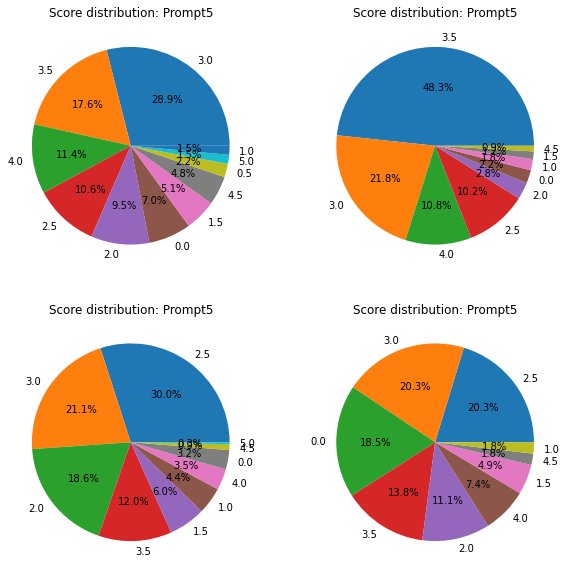

In [39]:
fig = plt.figure(figsize=(10,10))
prompt_id_list=[1,2,3,5]
for prompt in range(0,4):
  curdf=df[df['promptId']==prompt_id_list[prompt]]
  labels = []
  sizes = []
  for x, y in curdf.evaluator_rating.value_counts().items():
    labels.append(x)
    sizes.append(y)
  ax1 = plt.subplot2grid((2,2),((prompt)%2,math.floor((prompt)/2)))
  plt.pie(sizes,labels=labels,autopct='%1.1f%%')
  plt.title('Score distribution: Prompt'+str(prompt_id_list[i]))
plt.show()


**The following conclusions can be made from these series of pie charts:**

1. There is a big difference in the evaluation methods of each prompt (18.5% of total attendees of prompt 5 got zero marks, whereas the chance of getting zero in prompt 3 is only 3.2%)

2. The distribution of marks are not even, instead mostly scattered around 2.5-3.5

**AIM**: *To gather insights about evaluator's score versus average word length for each prompt*

Graph for evaluator rating vs avg word length


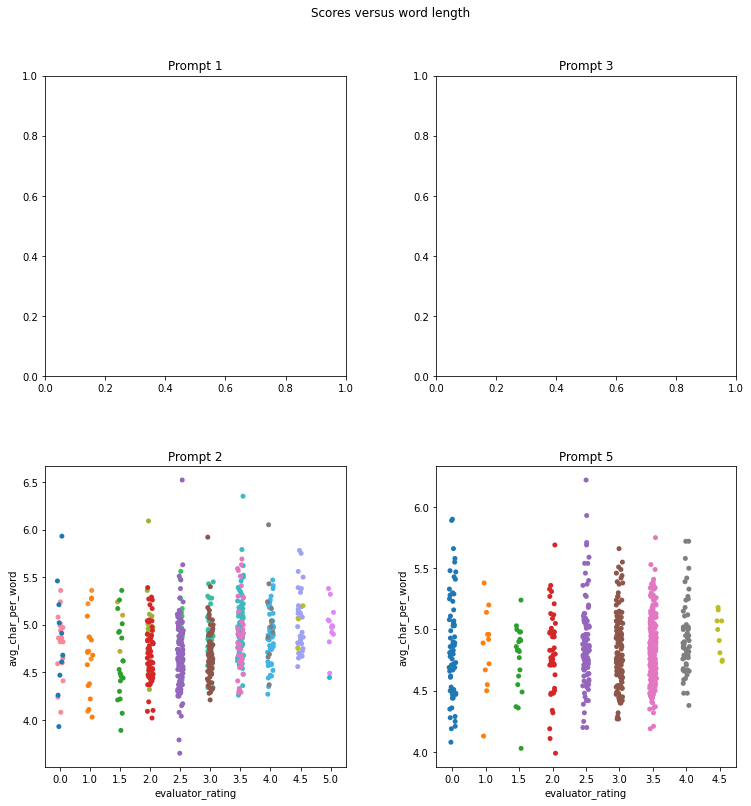

In [40]:
print("Graph for evaluator rating vs avg word length")

fig, axes = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Scores versus word length')

prompt_id_list=[1,2,3,5]
for prompt in range(0,4):
  curdf=df[df['promptId']==prompt_id_list[prompt]]  
  sns.stripplot(ax=axes[i%2,math.floor(prompt/2)],
    data=curdf,
    x="evaluator_rating", y="avg_char_per_word")
  axes[prompt%2,math.floor(prompt/2)].set_title("Prompt "+str(prompt_id_list[prompt]))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)
fig.show()



**The following conclusions can be made from these series of seaborn charts:**

1. There is variation of word length versus score with respect to the type of prompt. 

2. To the naked eye, no significant trend/pattern can be found which maps word-length to score

**AIM**: *To gather insights about evaluator's score versus total words used in an essay for each prompt*

Graph for evaluator rating vs total words in essay


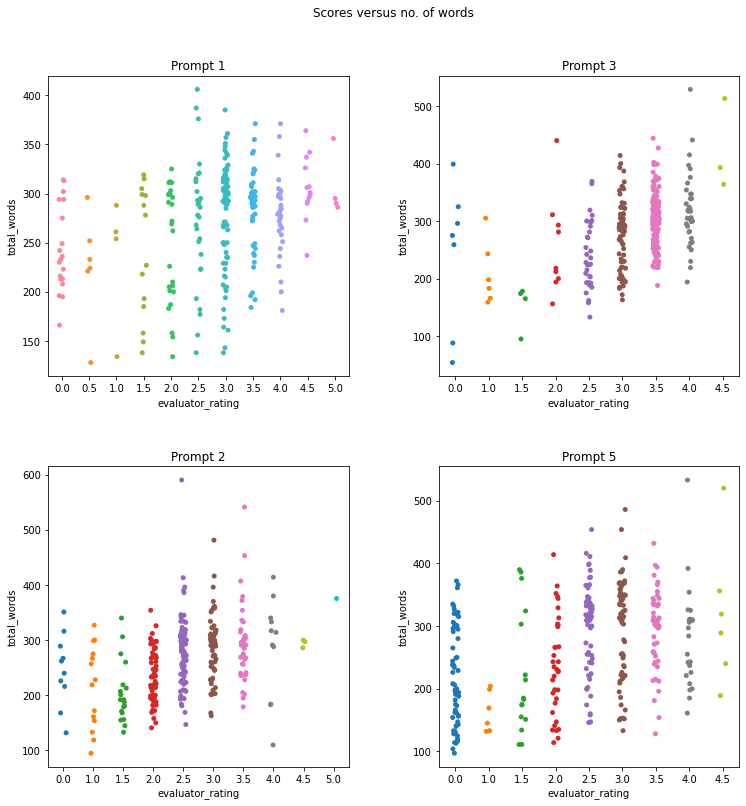

In [41]:
print("Graph for evaluator rating vs total words in essay")

fig, axes = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Scores versus no. of words')

prompt_id_list=[1,2,3,5]
for prompt in range(0,4):
  curdf=df[df['promptId']==prompt_id_list[prompt]]  
  sns.stripplot(ax=axes[prompt%2,math.floor(prompt/2)],
    data=curdf,
    x="evaluator_rating", y="total_words")
  axes[prompt%2,math.floor(prompt/2)].set_title("Prompt "+str(prompt_id_list[prompt]))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)
fig.show()



**The following conclusions can be made from these series of seaborn charts:**

1. The marks awarded is highly scattered across total words in all prompts. There are cases where 200+ words are used still less marks are awarded. 

2. Prompt 3 shows lesser scattering, and is the most "obedient" in terms of total-words-based-variance, while Prompt 1 performing the worst

**AIM**: *To find the presence/frequency of stopwords*

Stop Words in all essay prompts


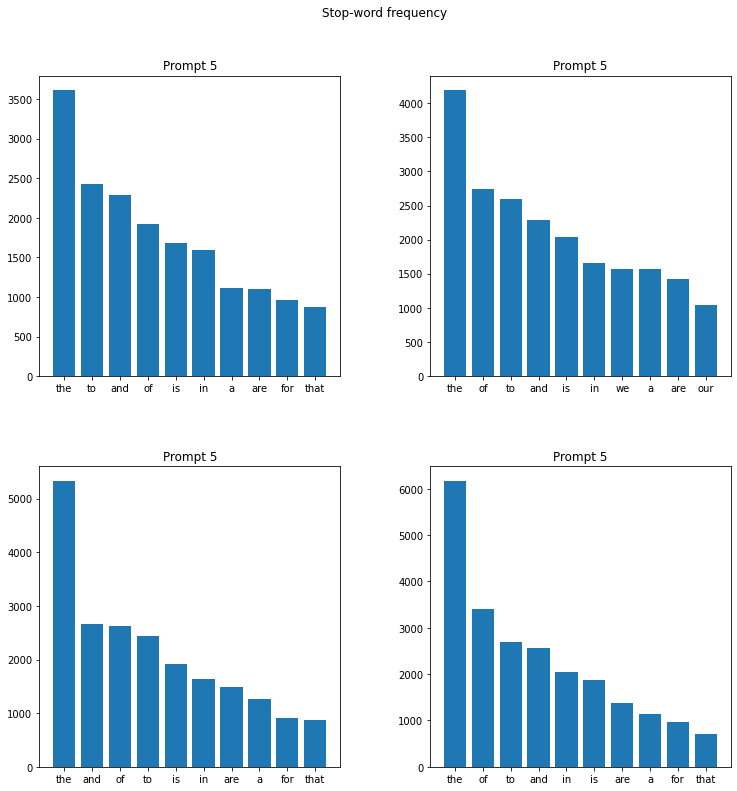

In [42]:
print("Stop Words in all essay prompts")

fig, axes = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Stop-word frequency')

prompt_id_list=[1,2,3,5]
for prompt in range(0,4):
  dct=defaultdict(int) 
  curdf=df[df['promptId']==prompt_id_list[prompt]]  
  for essay in curdf.essay:
    for word in essay.split():
      if word in STOP_WORDS:
          dct[word]+=1
  top=sorted(dct.items(), key=lambda x:x[1],reverse=True)[:10] 
  x,y=zip(*top)
  axes[prompt%2,math.floor(prompt/2)].bar(x,y)
  axes[prompt%2,math.floor(prompt/2)].set_title("Prompt "+str(prompt_id_list[i]))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)
fig.show()

        


From the above bar graphs, it is clear that a lot of stop-words are present, which raises the necessity to do stopword cleaning

**AIM**: *To find the presence/frequency of Punctuations*

Punctuations in all essay prompts


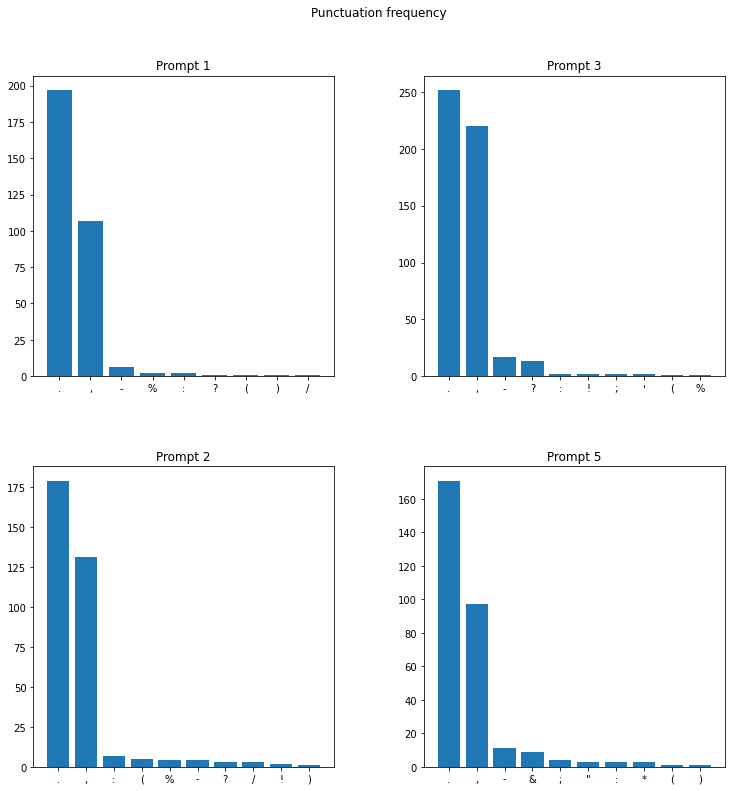

In [43]:
print("Punctuations in all essay prompts")

fig, axes = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Punctuation frequency')
special = string.punctuation

prompt_id_list=[1,2,3,5]
for prompt in range(0,4):
  dct=defaultdict(int) 
  curdf=df[df['promptId']==prompt_id_list[prompt]]  
  for essay in curdf.essay:
    for word in essay.split():
      if word in special:
          dct[word]+=1
  top=sorted(dct.items(), key=lambda x:x[1],reverse=True)[:10] 
  x,y=zip(*top)
  axes[prompt%2,math.floor(prompt/2)].bar(x,y)
  axes[prompt%2,math.floor(prompt/2)].set_title("Prompt "+str(prompt_id_list[prompt]))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)
fig.show()


Hence, it is clear that punctuations also need to be removed.

**AIM**: *To find the words that occur commonly under each prompt*

Most commonly occcuring words in all essay prompts


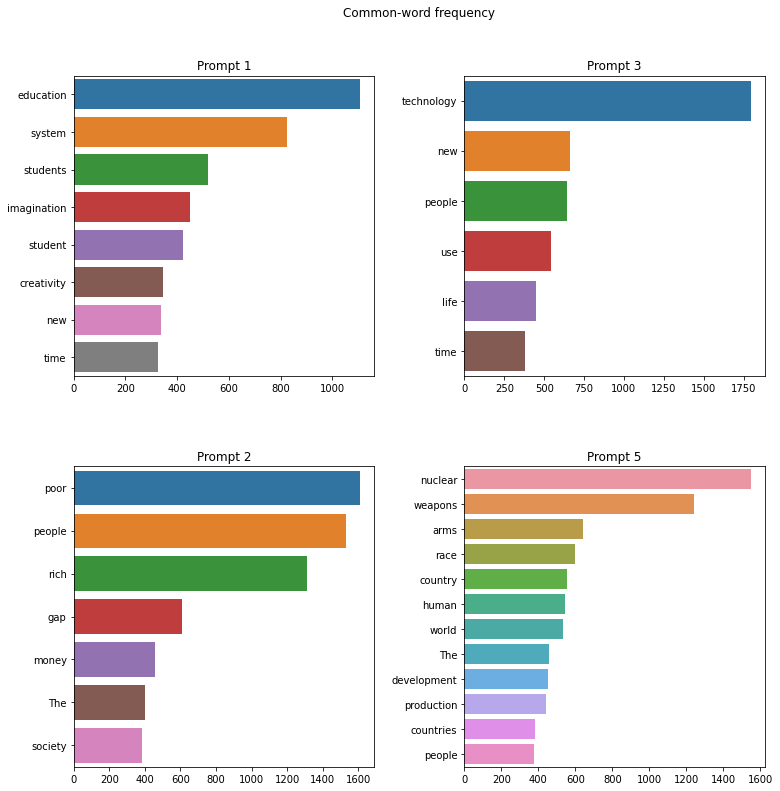

In [44]:
print("Most commonly occcuring words in all essay prompts")

fig, axes = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Common-word frequency')

prompt_id_list=[1,2,3,5]
for prompt in range(0,4):
  dct=defaultdict(int) 
  curdf=df[df['promptId']==prompt_id_list[prompt]]  
  counter=Counter((" ".join(curdf.essay)).split())
  most=counter.most_common()
  x=[]
  y=[]
  for word,count in most[:40]:
      if (word not in STOP_WORDS) :
          x.append(word)
          y.append(count)
  sns.barplot(ax=axes[prompt%2,math.floor(prompt/2)],x=y,y=x)
  axes[prompt%2,math.floor(prompt/2)].set_title("Prompt "+str(prompt_id_list[prompt]))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)
fig.show()


The following conclusions can be drawn from this graph:
1. Most frequently occuring words are highly related to the topic of the prompt ("education" in prompt 1 correlates to the education-based description of prompt 1, and so on)
2. There is a respectable amount different non-stop-words that occur frequently under each prompt, which makes it fairly straight-forward to incorporate the richness into the autocoring model.

**AIM**: *To analyse most-occuring bigrams in essays of all prompts* 

Bigram analysis


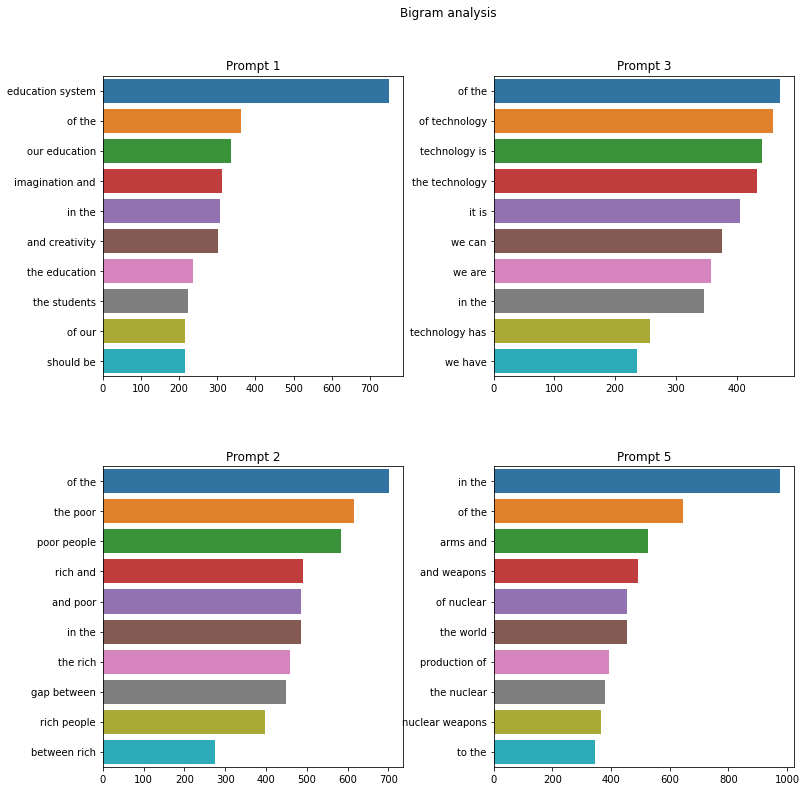

In [45]:
def get_top_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

print("Bigram analysis")

fig, axes = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Bigram analysis')

prompt_id_list=[1,2,3,5]
for prompt in range(0,4):
  dct=defaultdict(int) 
  top_bigrams=get_top_bigrams(df[df['promptId']==prompt_id_list[prompt]].essay)[:10]
  x,y=map(list,zip(*top_bigrams))
  sns.barplot(ax=axes[prompt%2,math.floor(prompt/2)],x=y,y=x)
  axes[prompt%2,math.floor(prompt/2)].set_title("Prompt "+str(prompt_id_list[prompt]))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)
fig.show()



The following inferences can be drawn WRT the above graphs:
1. Bi-gram popularity is directly related to topic of prompt
2. Stop-words need to be removed to make bi-grams more content-related

## **STEP TWO**: Text Cleaning
------
1. Convert to lowercase
2. Treat punctuations
3. Remove numbers
4. Remove emojis, URLs and HTMLs (if any)
4. Spell-correct
5. Stop word removal
5. Stem and Lemmatise

In [14]:
## Text cleaning


punctuation_counter=0
digit_counter=0

# Translates punctuations to space, and then removes multiple spaces
def remove_punct(text):
    global punctuation_counter
    for i in string.punctuation:
      punctuation_counter+=text.count(i)
    
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    text=text.translate(translator)
    return re.sub(' +', ' ', text)


# Replaces digits with whitespaces, and removes multiple spaces
def remove_digits(text):
    global digit_counter
    for c in ["0","1","2","3","4","5","6","7","8","9"]:
        digit_counter+=text.count(c)

    text = re.sub(r'[0-9]', ' ', text)
    return re.sub(' +', ' ', text)



# Removes all html tags that are of form <>
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)


# Removes all hyperlinks (if any)
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


# Removes all emojis (if any)
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#Applies lemmatization
def lemmatize(text):
     return " ".join(map(lambda x : x.lemma_, sp(text)))

#Corrects mispelled words
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

def stopwords(text):
  return " ".join(map(lambda x : x.lemma_,
                      [token for token in sp(text) if not token.is_stop]))


def cleaner(text):
  text=text.lower()
  text=remove_html(text)
  text=remove_URL(text)
  text=remove_emoji(text)
  text=remove_punct(text) 
  text=remove_digits(text)
  text=correct_spellings(text) #This function consumes a lot of run-time
  text=stopwords(text)
  text=lemmatize(text)
  return text

example_string="HELLO56,MY WORDD :) HTTPS://WWW.GITHUB.COM, SUP?"

print("Cleaned version of '",example_string,"' is: ",cleaner(example_string))

Cleaned version of ' HELLO56,MY WORDD :) HTTPS://WWW.GITHUB.COM, SUP? ' is:  hello world sup


In [15]:
df['corpus']=df.essay.apply(lambda x: cleaner(str(x)))
#df=pd.read_csv('cleaned.csv')
print('Cleaning done, \nPunctuations removed: ',punctuation_counter,'\nDigits removed: ',digit_counter)
df.head()

Cleaning done, 
Punctuations removed:  30403 
Digits removed:  2157


,promptId,uniqueId,essay,evaluator_rating,avg_char_per_word,total_words,corpus
0,1,1_323,"At present age, our education system is not go...",3.0,4.59,306,present age education system good thing requir...
1,1,1_238,I am agree the tightly defined curriculum of o...,4.0,5.78,299,agree tightly define curriculum education syst...
2,1,1_212,I strongly agree with the statement that tight...,2.0,4.78,158,strongly agree statement tight schedule educat...
3,1,1_117,Our education system is nice quitely but i dis...,2.0,4.91,312,education system nice quitely disagree change ...
4,1,1_229,i am totally agree with the statement that tig...,3.0,4.36,339,totally agree statement tightly define curricu...


Hence, upon making keen observations from the EDA, the approach to the NLP pipeline is as follows:
1. Treat this as a multi-class classification problem (score from 0 to 5 is discrete and hence class-based)
2. Develop separate models for separate prompts
3. Clean (correct spellings, remove digits and punctuations)
4. Feature engineer (Tokenise and convert to sequence of numbers)
5. Make cross validation sets
6. LSTM-net model

## **STEP THREE**: Feature Engineering

1. Tokenise
2. Convert to sequence of digits
3. Pad


In [106]:
dataset=[]
idx=0
prompt_to_index=dict()

score_dict={}
class_dict={}
for i in np.arange(0.0,5.5,0.5):
  class_dict[i]=i*2;
  score_dict[i*2]=i;

df['class']=df.evaluator_rating.apply(lambda x:class_dict[x]);
for i in df.promptId.unique():
  dataset.append(df[df.promptId==i])
  prompt_to_index[i]=idx
  idx+=1


In [107]:
# Create tokenizers (objects that convert text to vectors) and sequence vectors
# For each prompt separately

tokenizer = []
sequences=[]
labels=[]
for prompt in range(0,4):
  tokenizer_curr=Tokenizer() 
  tokenizer_curr.fit_on_texts(dataset[prompt].corpus) 
  sequence_curr=tokenizer_curr.texts_to_sequences(dataset[prompt].corpus)
  word_index = tokenizer_curr.word_index   
  print('Found ',len(word_index),' unique tokens for prompt ' ,prompt, ' With ',len(sequence_curr),' essays, and the maximum string length being ',max([len(i) for i in sequence_curr]))
  sequence_curr = pad_sequences(sequence_curr, maxlen=MAX_SEQUENCE_LENGTH)
  
  tokenizer.append(tokenizer_curr)
  sequences.append(sequence_curr)
  labels.append(np.asarray(dataset[prompt].evaluator_rating))
  #labels.append(to_categorical(np.asarray(dataset[prompt]['class'])))
  

Found  3590  unique tokens for prompt  0  With  273  essays, and the maximum string length being  171
Found  3969  unique tokens for prompt  1  With  317  essays, and the maximum string length being  247
Found  4508  unique tokens for prompt  2  With  325  essays, and the maximum string length being  230
Found  4302  unique tokens for prompt  3  With  325  essays, and the maximum string length being  260


In [69]:
'''
# Split the training data into a training set and a validation set
# Note that each list stores 4 sets:- train/val sets of each prompt
x_train=[] 
y_train=[]
x_val=[]
y_val=[]

for prompt in range(0,4):
  indices = np.arange(sequences[prompt].shape[0])
  np.random.shuffle(indices)
  train_cur = sequences[prompt][indices]
  train_labels = labels[prompt][indices]
  val_samples = math.ceil(VALIDATION_SPLIT * sequences[prompt].shape[0])
  x_train.append(sequences[prompt][:-(val_samples)])
  y_train.append(labels[prompt][:-(val_samples)])
  x_val.append(sequences[prompt][-(val_samples):])
  y_val.append(labels[prompt][-(val_samples):])
#This is the data we will use for CNN and RNN training
print('Splitting the train data into train and valid is done')

for prompt in range(0,4):
  print('x-train and x-val shape for prompt ',prompt,': ',x_train[prompt].shape,' and ',x_val[prompt].shape)
  
  print('y-train and y-val shape for prompt ',prompt,': ',y_train[prompt].shape,' and ',y_val[prompt].shape)

'''

Splitting the train data into train and valid is done
x-train and x-val shape for prompt  0 :  (218, 500)  and  (55, 500)
y-train and y-val shape for prompt  0 :  (218,)  and  (55,)
x-train and x-val shape for prompt  1 :  (253, 500)  and  (64, 500)
y-train and y-val shape for prompt  1 :  (253,)  and  (64,)
x-train and x-val shape for prompt  2 :  (260, 500)  and  (65, 500)
y-train and y-val shape for prompt  2 :  (260,)  and  (65,)
x-train and x-val shape for prompt  3 :  (260, 500)  and  (65, 500)
y-train and y-val shape for prompt  3 :  (260,)  and  (65,)


## **STEP FOUR**: Model building

We develop a model that has
- an embedding layer
- LSTM with dropout
- LSTM with dropout
- Dense
- single node output

The model will be:
- evaluated by RMS
- hypertuned by adam

In [ ]:
model=[]
history=[]
for prompt in range(0,4):
  rnnmodel = Sequential()
  rnnmodel.add(Embedding(MAX_NUM_WORDS, EMBEDDING_DIM))
  rnnmodel.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
  rnnmodel.add(Dense(32, activation='relu'))
  rnnmodel.add(Dense(1, activation='relu'))
  rnnmodel.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mae'])
  print(rnnmodel.summary())
  fold=0
  for train_index, test_index in KFold(5,shuffle=True).split(sequences[prompt]):
    print('\n Prompt ',prompt,' Fold ',fold)
    x_train, x_val = sequences[prompt][train_index], sequences[prompt][test_index]
    y_train, y_val = labels[prompt][train_index], labels[prompt][test_index]
    his=rnnmodel.fit(x_train, y_train,
            batch_size=32,
            epochs=100,
            validation_data=(x_val, y_val))
    
    path = "/content/gdrive/My Drive/aes_born_"+str(prompt)+".h5" 
    rnnmodel.save(path)

    plt.plot(his.history['loss'])
    plt.plot(his.history['val_loss'])
    plt.title('PROMPT '+str(prompt)+' fold '+str(fold))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
  
    history.append(his)
    fold+=1

    # summarize history for loss

  model.append(rnnmodel)

print('all done')

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, None, 100)         500000    
_________________________________________________________________
lstm_31 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dense_38 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 33        
Total params: 621,409
Trainable params: 621,409
Non-trainable params: 0
_________________________________________________________________
None

 Prompt  0  Fold  0
Epoch 1/100
7/7 [==============================] - 14s 2s/step - loss: 8.6699 - mae: 2.7207 - val_loss: 7.5515 - val_mae: 2.5320
Epoch 2/100
7/7 [==============================] - 11s 2s/step - loss: 3.9039 - mae: 1.637